LEIDY TATIANA ROJAS FORERO - C0923904

In [15]:
# Set up the environment
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Intel dataset
!kaggle datasets download -d puneet6060/intel-image-classification -p /content

# Unzip the ZIP file
!unzip /content/intel-image-classification.zip -d /content/intel-image-classification



Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
Archive:  /content/intel-image-classification.zip
replace /content/intel-image-classification/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

 1.	Data Loading and Preprocessing

In [24]:
#Trainig data
train_datagen = ImageDataGenerator(rescale = 1./255, # Normalize pixel values between 0 and 1
                                   rotation_range=20, # Randomly rotate images up to 20 degress
                                   width_shift_range=0.1, #Random horizontal shifts
                                   height_shift_range=0.1, #Random Vertical shifts
                                   shear_range=0.2, # Simulates small geometric distortions
                                   zoom_range=0.2,  #Random zoom up to 20%
                                   horizontal_flip=True, #Random horizontal flipping
                                   validation_split=0.2) #Reserve 20% data for validation

training_set=train_datagen.flow_from_directory('/content/intel-image-classification/seg_train/seg_train',
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical',
                                               subset='training'
                                               )
#validation data
validation_set=train_datagen.flow_from_directory('/content/intel-image-classification/seg_train/seg_train',
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical',
                                               subset='validation'
                                                 )
print(training_set.class_indices)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [32]:
#Testing data
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set=test_datagen.flow_from_directory('/content/intel-image-classification/seg_test/seg_test',
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False)

print(training_set.class_indices)

Found 3000 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


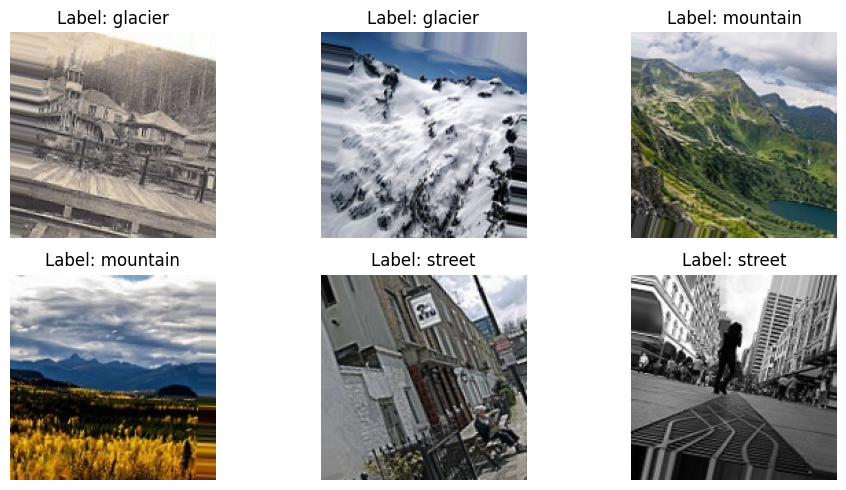

In [33]:
# Display Sample Images
class_names = list(training_set.class_indices.keys())
x_batch, y_batch = next(training_set)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    label = class_names[np.argmax(y_batch[i])]
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

2. Model Building

In [26]:
# model building
cnn=tf.keras.models.Sequential() #Intializing the model

# add convolutional layer 1
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[150,150,3]))
# add pooling layer 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# add convolutional layer 2
cnn.add(tf.keras.layers.Conv2D(filters=96, kernel_size=3, activation='relu'))
# add pooling layer 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#dropout
cnn.add(tf.keras.layers.Dropout(0.4))
# flatten the layer
cnn.add(tf.keras.layers.Flatten())

# fully connected layer 1
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# fully connected layer 2
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# output layer
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 36, 36, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 124416)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      15,925,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,991,206 (61.00 MB)

 Trainable params: 15,991,206 (61.00 MB)

 Non-trainable params: 0 (0.00 B)

3. Model Training

In [27]:
#compile model
cnn.compile(
    loss='categorical_crossentropy', #is multiclass problem
    optimizer=Adam(),
    metrics=['accuracy']
)

#train model
history = cnn.fit(
    training_set,
    validation_data=validation_set,
    epochs=20,
    batch_size=32
)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 235ms/step - accuracy: 0.4495 - loss: 1.4220 - val_accuracy: 0.6484 - val_loss: 0.8968
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 138s 228ms/step - accuracy: 0.6727 - loss: 0.8695 - val_accuracy: 0.6840 - val_loss: 0.8310
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - accuracy: 0.7004 - loss: 0.7962 - val_accuracy: 0.7397 - val_loss: 0.7081
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.7328 - loss: 0.7151 - val_accuracy: 0.7457 - val_loss: 0.7005
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.7465 - loss: 0.6801 - val_accuracy: 0.7703 - val_loss: 0.6552
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.7489 - loss: 0.6632 - val_accuracy: 0.7743 - val_loss: 0.6104
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.7710 - loss: 0.6234 - val_accuracy: 0.7907 - val_loss: 0.5970
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.7715 - loss: 

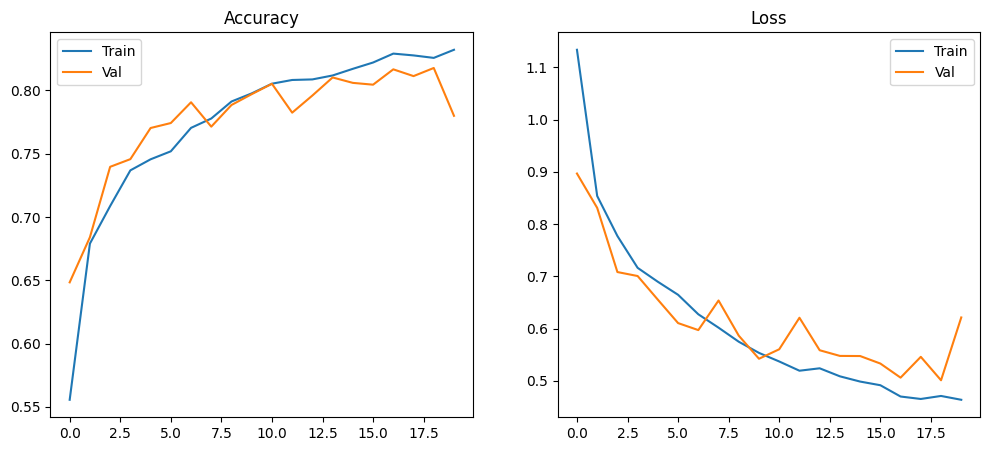

In [44]:
# Plot Accuracy and Loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

4. Model Evaluation

 1/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8438 - loss: 0.4063

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8723 - loss: 0.3715
Test Accuracy: 0.82
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
              precision    recall  f1-score   support

   buildings       0.79      0.88      0.83       437
      forest       0.89      0.98      0.93       474
     glacier       0.79      0.81      0.80       553
    mountain       0.72      0.81      0.76       525
         sea       0.86      0.72      0.78       510
      street       0.92      0.76      0.83       501

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.82      3000
weighted avg       0.83      0.82      0.82      3000



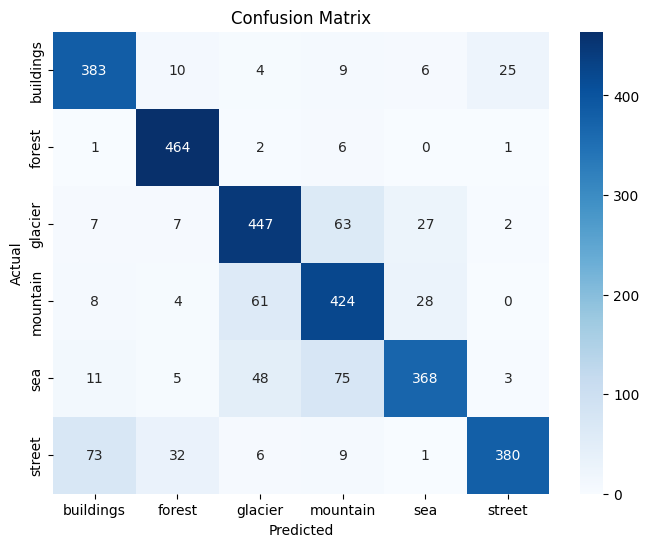

In [34]:
# Evaluate on Test Set
loss, acc = cnn.evaluate(test_set)
print(f"Test Accuracy: {acc:.2f}")

#Classification Report and Confusion Matrix
y_pred = cnn.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
idx_to_class = {v: k for k, v in training_set.class_indices.items()}

print(classification_report(y_true, y_pred_classes, target_names=idx_to_class.values()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

5. Visualization and Interpretation

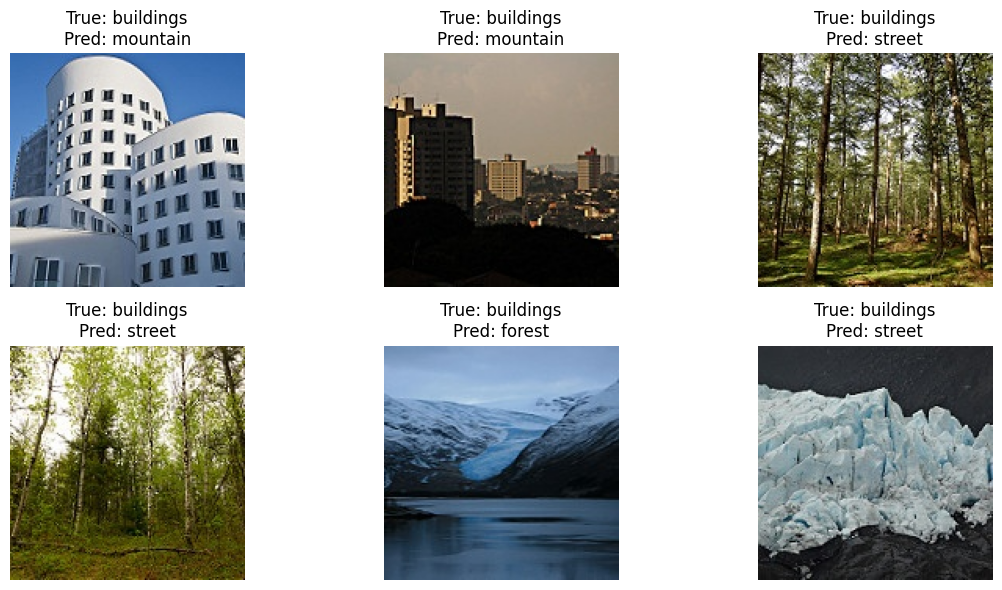

In [42]:
# Misclassified Images
errors = np.where(y_pred_classes != y_true)[0]
plt.figure(figsize=(12, 6))
for i, idx in enumerate(errors[:6]):
    img = test_set[idx][0][0]
    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[y_pred_classes[idx]]
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Feature Maps (from first conv layer)

# Force the model to build by calling it once
_ = cnn.predict(x_batch[:1])  # Call the model to define input/output tensors

from tensorflow.keras import Model

# Now that the model is built, you can safely access cnn.input
layer_outputs = [layer.output for layer in cnn.layers[:3]]
activation_model = Model(inputs=cnn.input, outputs=layer_outputs)

# Get activations for one image
activations = activation_model.predict(x_batch[:1])

# Visualize the feature maps of the first convolutional layer
first_layer_activation = activations[0]
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.title(f"Filter {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()